# Обучение нейронной сети Stardist 

In [1]:
#pip install stardist
#pip install tensorflow
#pip install opencv-python
#!pip install csbdeep

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [3]:
X = sorted(glob('images_train_cells/*.tif'))
Y = sorted(glob('Masks_train_cells/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

Преобразование в список изображений и замена формата при необходимости

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Нормализация изображений и заполение небольших пробелов в масках изображений при наличии таковых

In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 95.49it/s]


Разделение изображений на тренировочную выборку и валидационную. Размер валидационной относительно всей регулируется параметром n_val, нужно изменить значение 0.05 в сторону увеличения, чтобы увеличилось количество валидационных фотографий. (В первой нейросети я использовала 3 валидационных и она сработала лучше, мб вообще-то из-за этого. Чет я протупила, но еще 2 часа на обучение тратить лениво)

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.05 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  16
- training:        15
- validation:       1


Обучающие данные состоят из пар экземпляров входного изображения и маски

In [8]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

Выведем пример

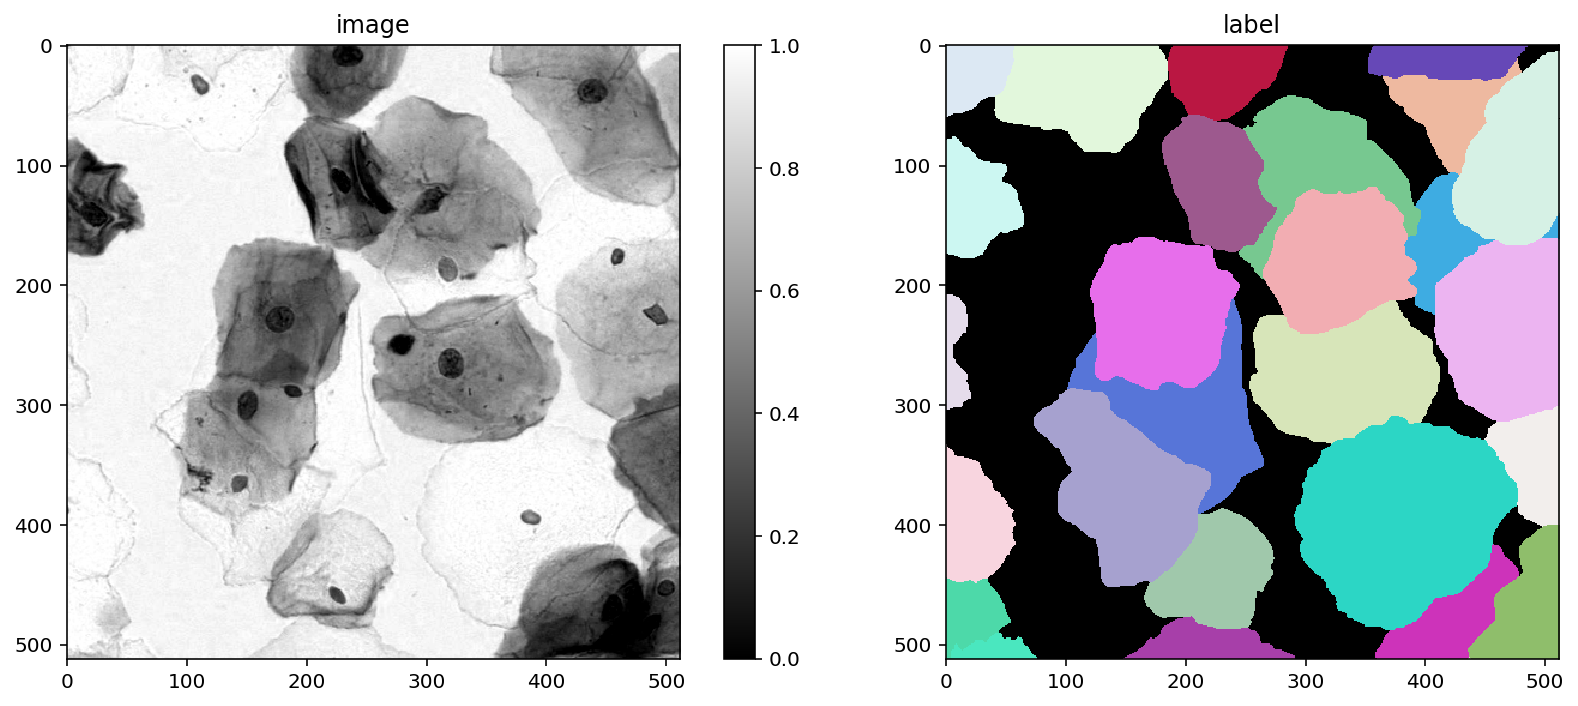

In [13]:
i = 3
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

## Конфигурация
Здесь выводим конфигурацию стардиста по умолчанию, можно посмотреть на каждый используемый параметр для последующего изменения

Будем использовать 2D модель, поэтому все тренировочные фотки имеют размер 512 на 512 и содержат лишь 1 канал (инентивность в оттенках чб)

In [16]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

Здесь меняем необходимые параметры конфиругации (количество лучей n_rays, размер окна зрения нейронной сети grid, рекомендованное кстати (2, 2), но мы в него некоторыми клетками полностью не влезали, они тупо больше, поэтому пришлось увеличить в два раза, что скорее всего сказалось на точности; параметр train_epochs влияет на количество эпох обучения, то есть переопределения весов нейронов)

Тут можно будет менять число эпох и число лучей при создании звездоподобного патерна

In [48]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False  #!!!

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (4, 4)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_epochs = 800,
    train_shape_completion=True
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(4, 4), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=True, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, u

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (4, 4),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': True,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 800,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 

In [49]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

Здесь создание модели

In [50]:
model = StarDist2D(conf, name='stardist', basedir='models')

Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.481503, nms_thresh=0.3.


Вот тут как раз проводится проверка, попадает ли каждый объект наш в поле зрения нейросети, из-за этого пришлось менять размер на (4, 4)

In [51]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

1/1 [==============================] - 0s 87ms/step
median object size:      [106.  109.5]
network field of view :  [189 188]


## Аугментация данных

Здесь проводится аугментация данных для последюущего обучения нейросети, для этого рализованы функции поворота изображения random_fliprot и функция изменения интенсивности (ну типа яркости пикселей) на случайное число random_intensity_change

In [52]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Тут парочка примеров аугментированных изображений

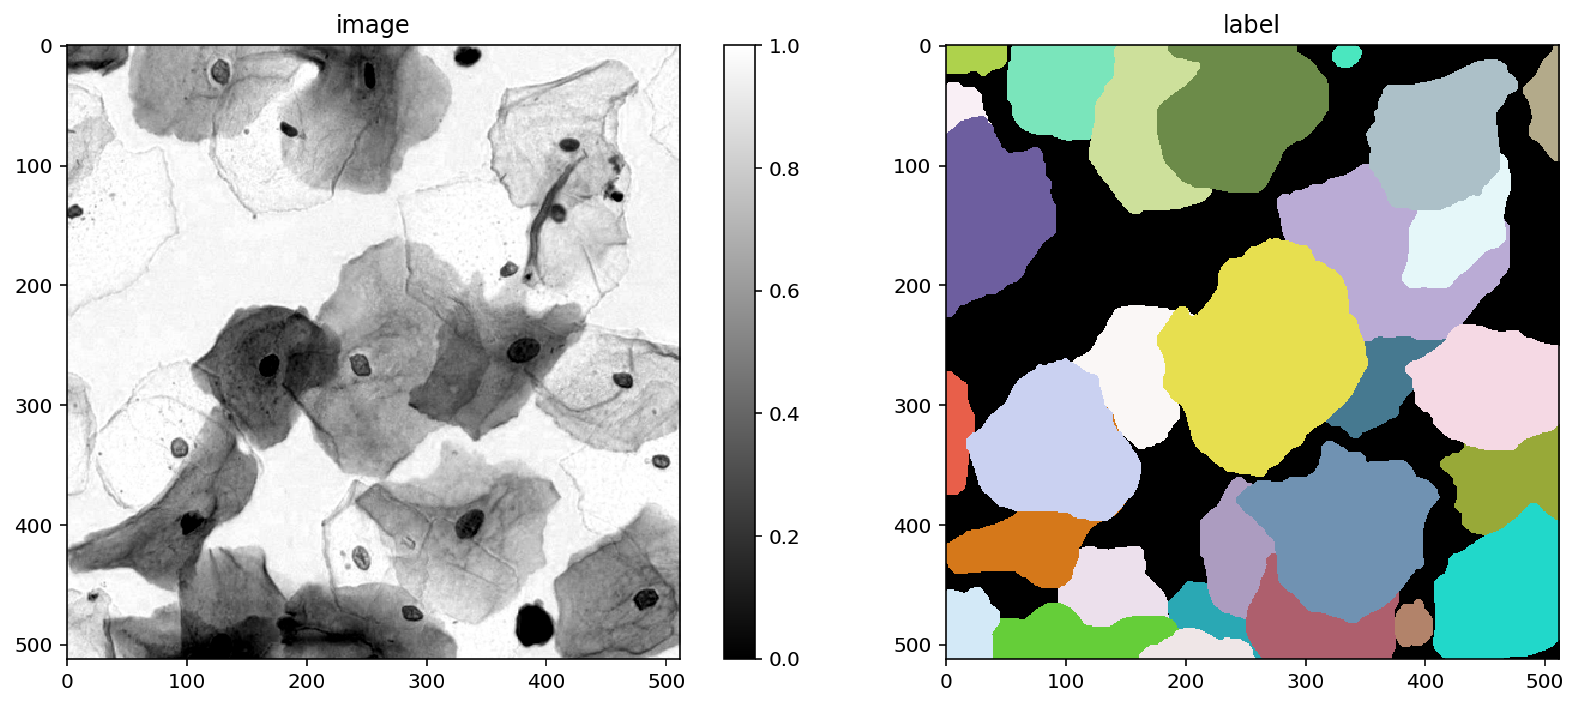

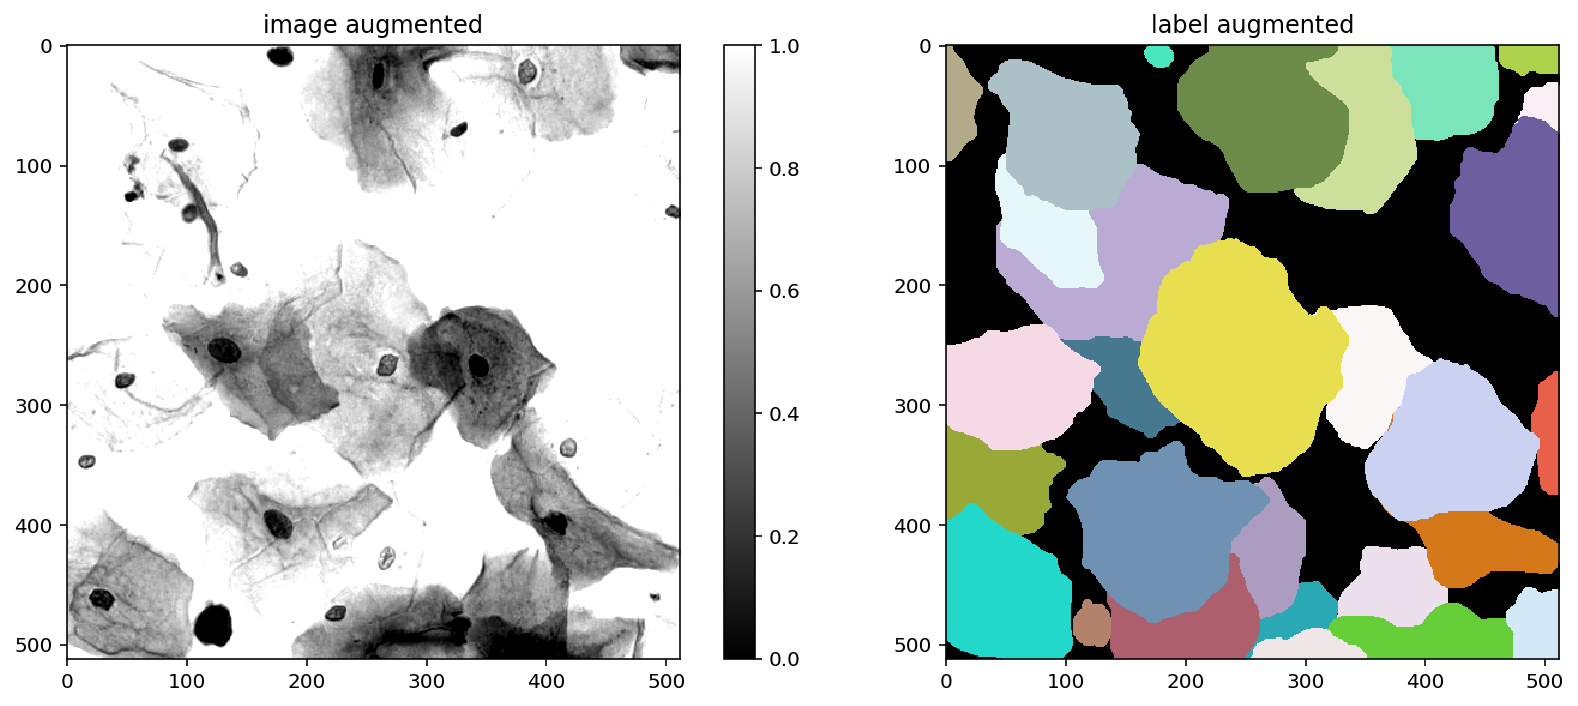

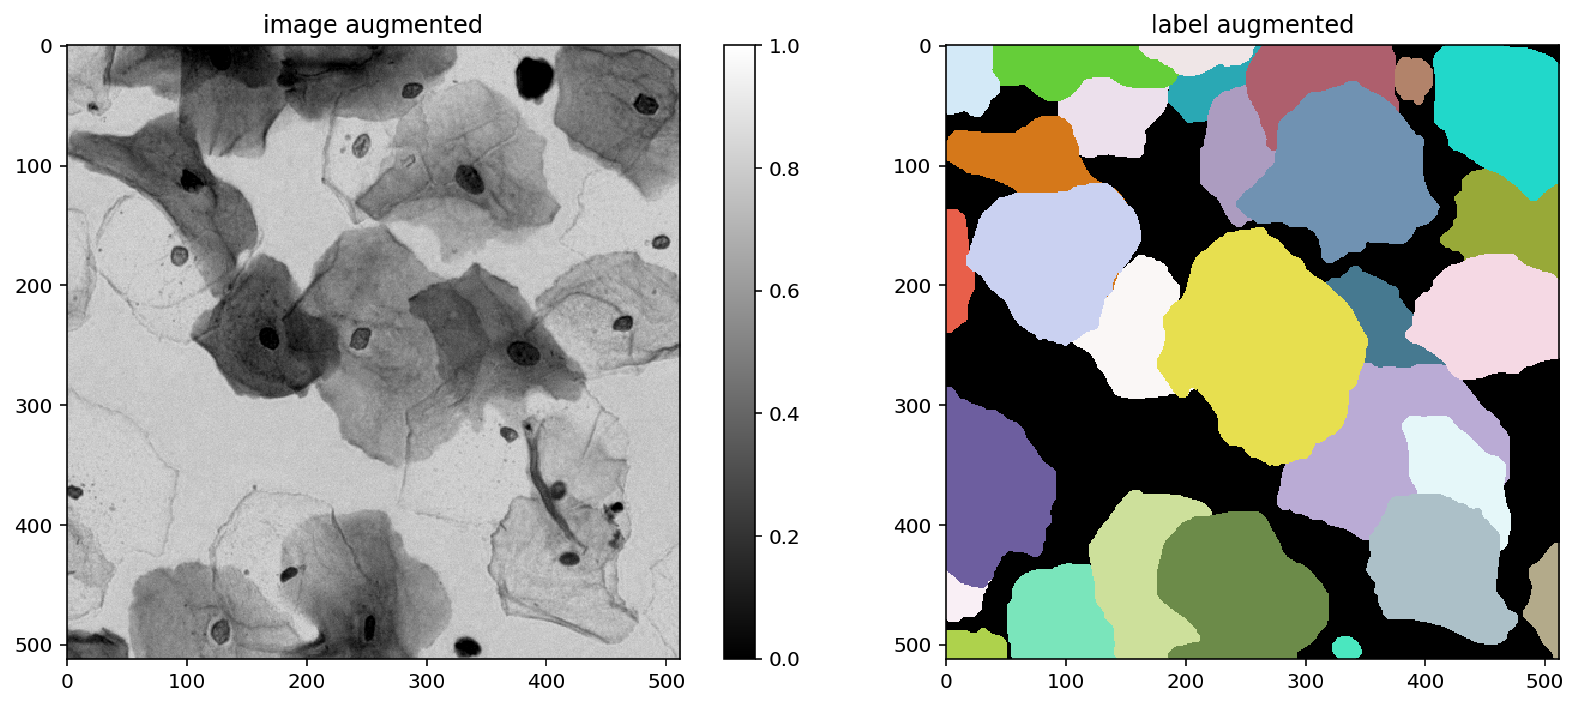

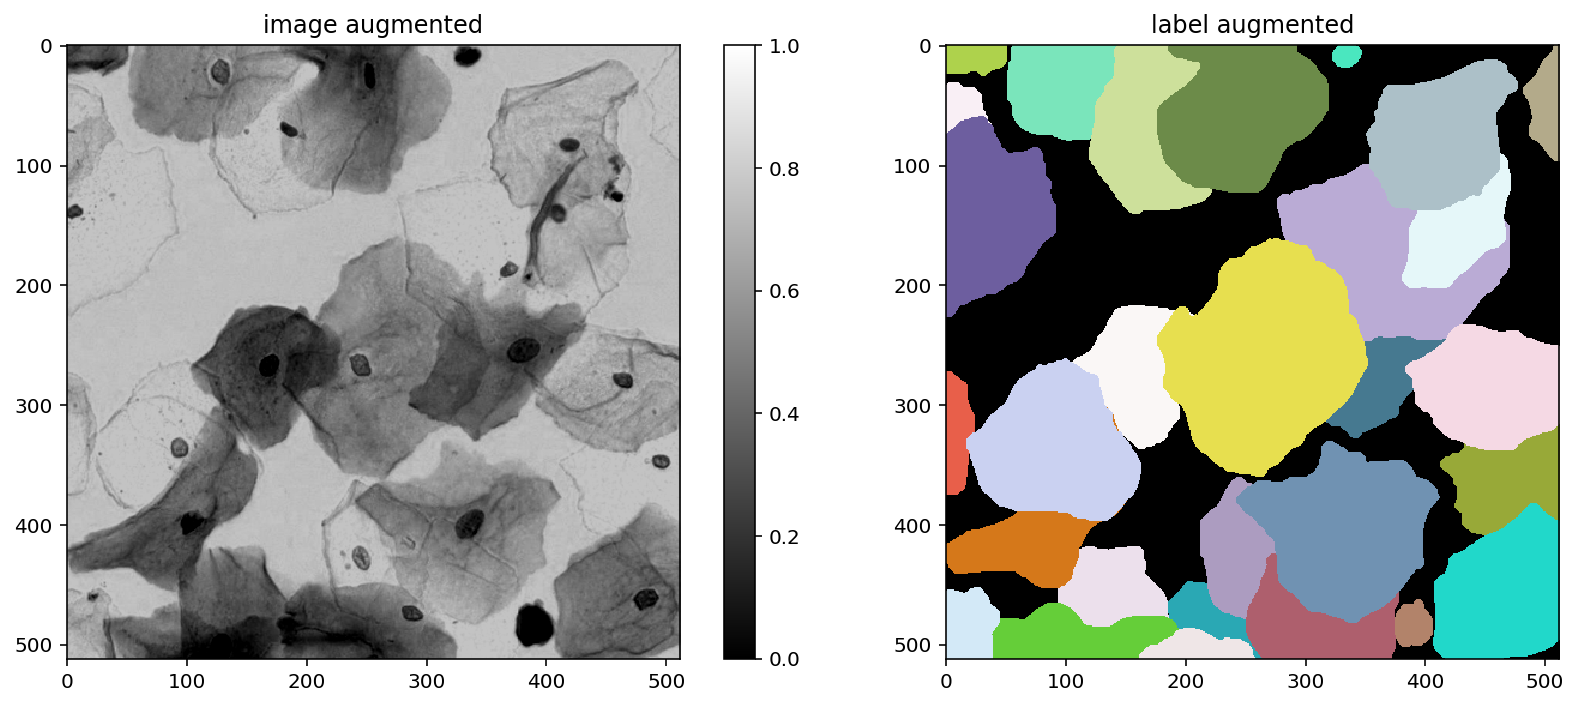

In [53]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

## Обучение

In [54]:
#!pip install gputools

In [63]:
quick_demo = True  # При реальном обучении поставить False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=5, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

NOTE: This is only for a quick demonstration!
      Please set the variable 'quick_demo = False' for proper (long) training.


Epoch 1/5
10/10 [==============================] - 21s 2s/step - loss: 5.9136 - prob_loss: 0.8138 - dist_loss: 25.4986 - prob_kld: 0.4168 - dist_relevant_mae: 25.4964 - dist_relevant_mse: 1247.8153 - dist_dist_iou_metric: 0.3017 - val_loss: 4.0666 - val_prob_loss: 0.5881 - val_dist_loss: 17.3923 - val_prob_kld: 0.2253 - val_dist_relevant_mae: 17.3894 - val_dist_relevant_mse: 554.2454 - val_dist_dist_iou_metric: 0.4312 - lr: 3.0000e-04
Epoch 2/5
10/10 [==============================] - 18s 2s/step - loss: 4.4608 - prob_loss: 0.6315 - dist_loss: 19.1465 - prob_kld: 0.2401 - dist_relevant_mae: 19.1437 - dist_relevant_mse: 755.8771 - dist_dist_iou_metric: 0.4003 - val_loss: 3.9122 - val_prob_loss: 0.5902 - val_dist_loss: 16.6102 - val_prob_kld: 0.2274 - val_dist_relevant_mae: 16.6071 - val_dist_relevant_mse: 496.7961 - val_dist_dist_iou_metric: 0.4627 - lr: 3.0000e-04
Epoch 3/5
10/10 [==============================] - 18s 2s/step - loss: 3.8999 - prob_loss: 0.6202 - dist_loss: 16.3985 - pr

====> Stopping training and loading previously trained demo model from disk.


Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


## Оптимизация порогового значения

Хотя значения по умолчанию для порогов вероятности и не максимального подавления уже дают хорошие результаты во многих случаях, мы все же рекомендуем адаптировать пороговые значения к вашим данным. Оптимизированные пороговые значения сохраняются на диске и будут автоматически загружены вместе с моделью. Именно это происходит в следующей ячейке

In [67]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 264ms/step


NMS threshold = 0.5:  70%|██████████████████████████████████████████                  | 14/20 [00:00<00:00, 46.33it/s, 0.816 -> 0.058]


Using optimized values: prob_thresh=0.819263, nms_thresh=0.3.


## Оценка качества модели

Для оценки предсказанных данных используется множество метрик. Про них можно прочитать подробнее по данной ссылке:
    http://recog.ru/меры-измерения-точности-при-детектир/

Сначала спрогнозируем метки для всех изображений проверки:

In [68]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|                                                                                                           | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 134ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


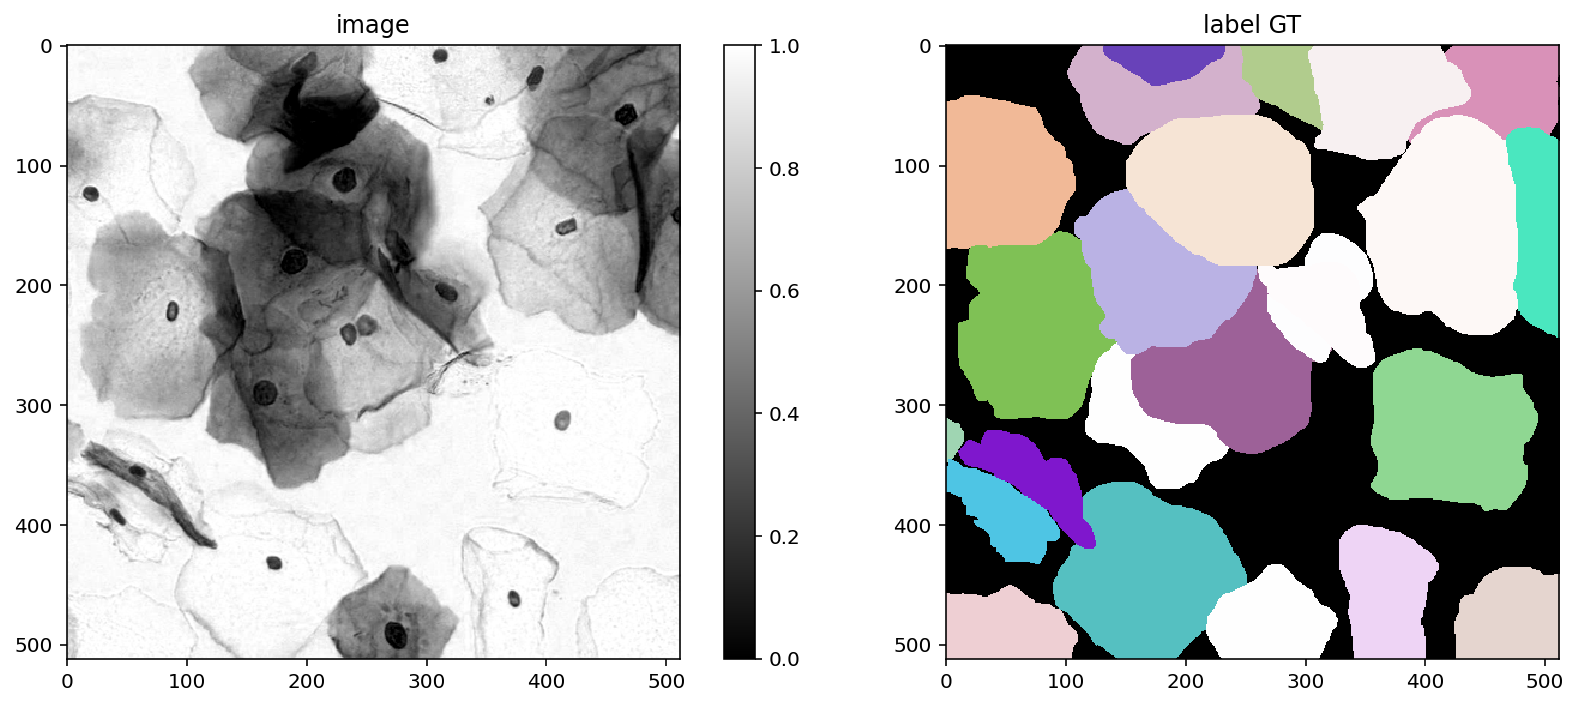

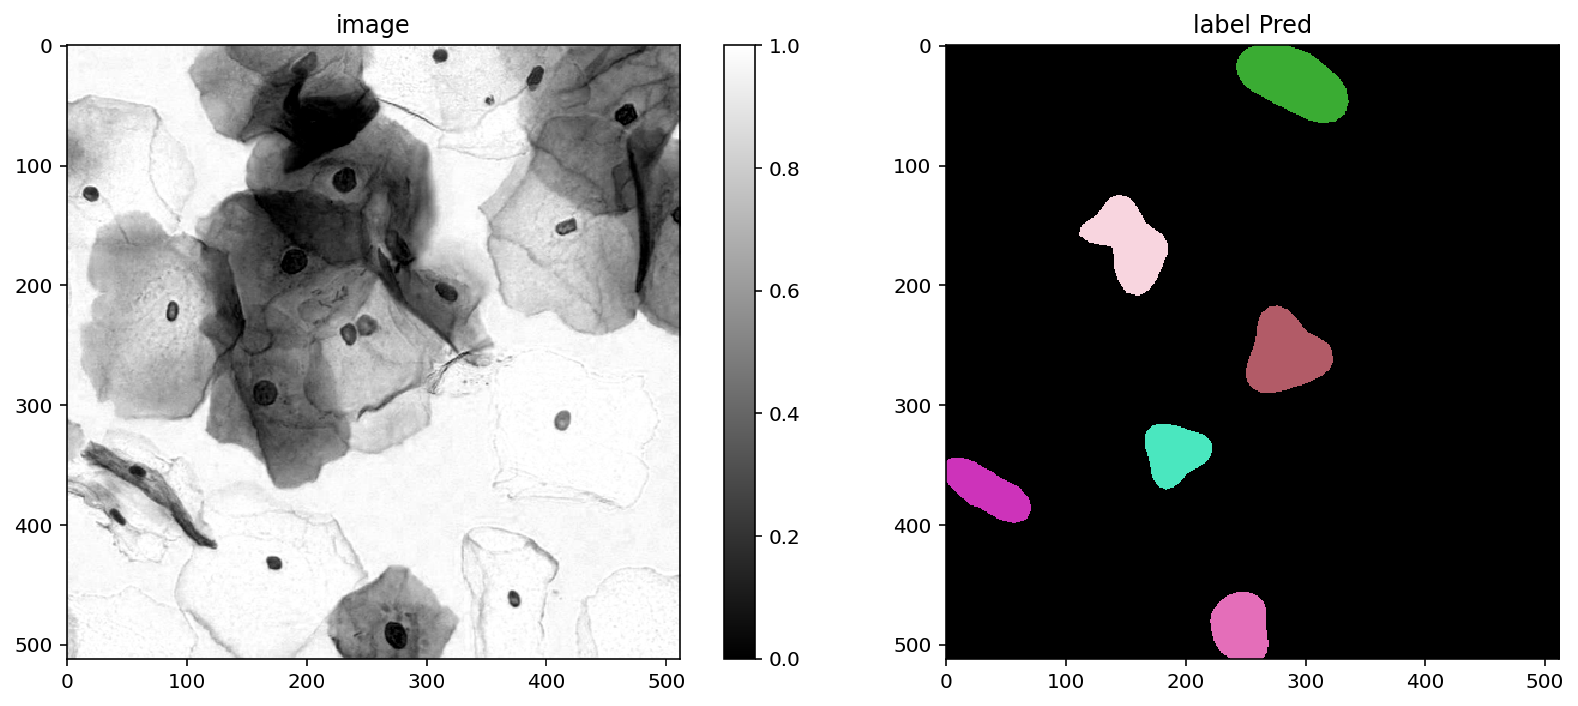

In [72]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

То есть мы выбираем пороговые значения

In [64]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 97.00it/s]


In [65]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=5, tp=1, fn=24, precision=0.16666666666666666, recall=0.04, accuracy=0.03333333333333333, f1=0.06451612903225806, n_true=25, n_pred=6, mean_true_score=0.026442861557006835, mean_matched_score=0.6610715389251709, panoptic_quality=0.042649776704849734, by_image=False)

__Строим статистику соответствия:__<br/> В примере включен режим демо для быстрой демонстрации, так что в конкретном примере метрики не являются объективными

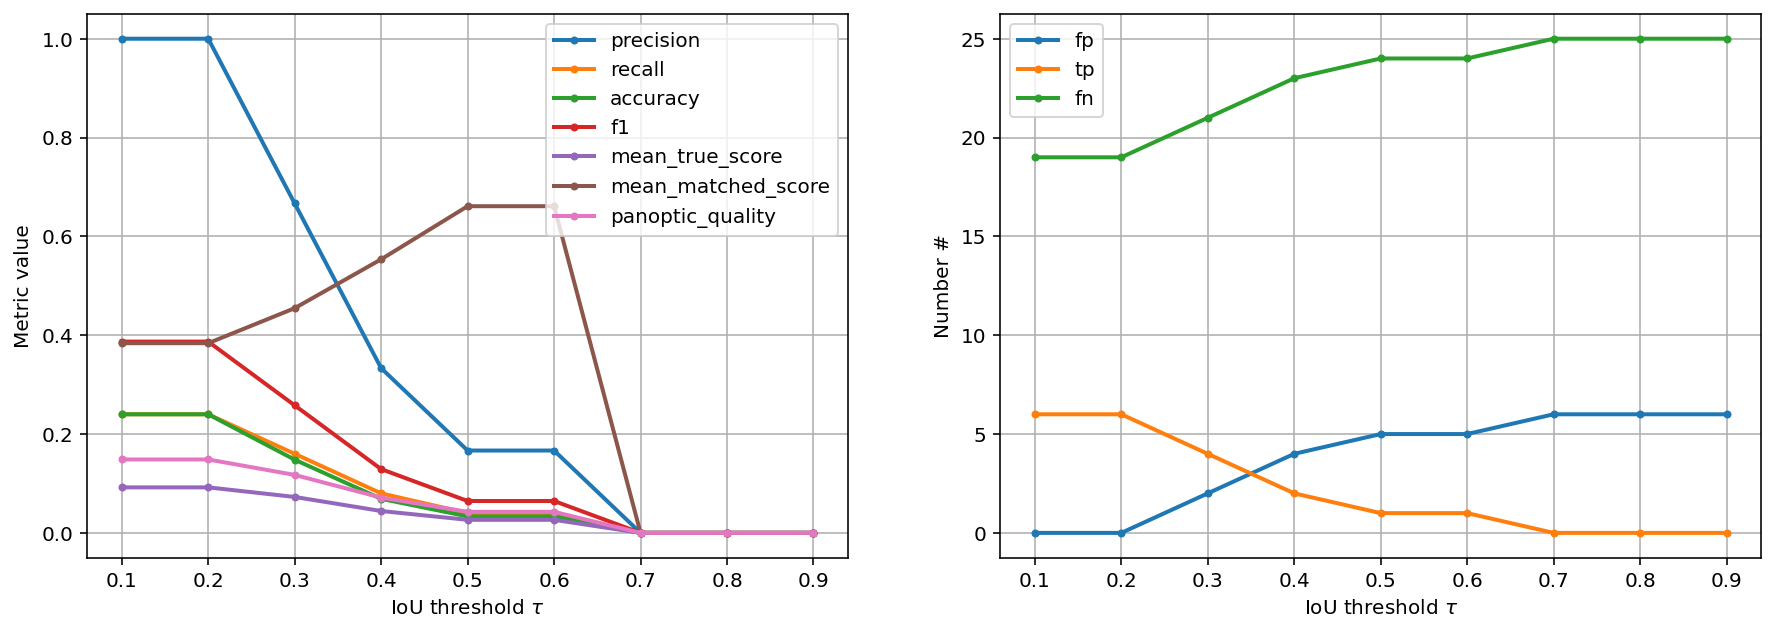

In [76]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();


По такому же принципу происходило обучение двух отдельных сетей для сегментации клеток, которые были записаны в архивы SD_models_400.zip (400 эпох обучения) и 
SD_models_800.zip (800 эпох обучения). <br/>
Параметры весов для нейронной сети, обученной на ядрах были записаны в архив SD_models_nuclei.zip

Так что данный прочитанный вами файл показывает лишь общие идеи и демо демонстрацию процесса обучения подобной сверточной сети. <br/> Основные результаты проделанной работы представлены в главном файле - _segmentation.ipynb_ <br/>Спасибо за внимание! 